In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

Using TensorFlow backend.


In [26]:
data=pd.read_csv("/content/drive/My Drive/train1.csv",nrows=100000)
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [27]:
data.drop_duplicates(subset=['Phrase'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Phrase']:
    cleaned_text.append(text_cleaner(t))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [30]:
data1=pd.read_csv("/content/drive/My Drive/test1.csv",nrows=100000)
data1.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [31]:
data1.drop_duplicates(subset=['Phrase'],inplace=True)  #dropping duplicates
data1.dropna(axis=0,inplace=True)   #dropping na
data1.head()
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text1 = []
for t in data1['Phrase']:
    cleaned_text1.append(text_cleaner(t))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'drive'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [32]:
data1["Phrase"].head

<bound method NDFrame.head of 0        An intermittently pleasing but mostly routine ...
1        An intermittently pleasing but mostly routine ...
2                                                       An
3        intermittently pleasing but mostly routine effort
4               intermittently pleasing but mostly routine
                               ...                        
66287               A long-winded , predictable scenario .
66288                 A long-winded , predictable scenario
66289                                      A long-winded ,
66290                                        A long-winded
66291                                 predictable scenario
Name: Phrase, Length: 66292, dtype: object>

In [0]:
data['Phrase']=cleaned_text
data1['Phrase']=cleaned_text1
data1['Phrase'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [35]:
for i in range(5):
    print("Review:",data['Phrase'][i])
    print("Summary:",data1['Phrase'][i])
    print("\n")

Review: series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story
Summary: intermittently pleasing mostly routine effort


Review: series escapades demonstrating adage good goose
Summary: intermittently pleasing mostly routine effort


Review: series
Summary: nan


Review: 
Summary: intermittently pleasing mostly routine effort


Review: series
Summary: intermittently pleasing mostly routine




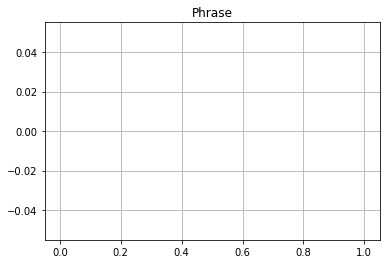

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


In [0]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import string 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [0]:
tokenizer=RegexpTokenizer(r'\w+')
str_tok=[]
for i in data["Phrase"]:
  str_tok.append(tokenizer.tokenize(i.lower()))

In [0]:
tokenizer=RegexpTokenizer(r'\w+')
str_tok1=[]
for i in data1["Phrase"]:
  str_tok1.append(tokenizer.tokenize(i.lower()))

In [41]:
str_tok[:5]

[['series',
  'escapades',
  'demonstrating',
  'adage',
  'good',
  'goose',
  'also',
  'good',
  'gander',
  'occasionally',
  'amuses',
  'none',
  'amounts',
  'much',
  'story'],
 ['series', 'escapades', 'demonstrating', 'adage', 'good', 'goose'],
 ['series'],
 [],
 ['series']]

In [44]:
pip install glove_python

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700322 sha256=32e41fae657b288d56bd9833af66e7cd090a5aff98462b097f2b4fc4b93363c2
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [45]:

#importing the glove library
from glove import Corpus, Glove
# creating a corpus object
corpus = Corpus() 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(str_tok, window=100)
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=100, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=30, no_threads=100, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 100 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [0]:
glove.add_dictionary(corpus.dictionary)

In [0]:
w2v=[]
for i in str_tok:
  for j in i:
    w2v.append(glove.word_vectors[glove.dictionary[j]])

In [50]:
w2v[:5]

[array([-0.03026908, -0.09859429,  0.07921089,  0.04764911,  0.00293711,
         0.15711462, -0.0008981 ,  0.03978121,  0.02109569, -0.00633435,
        -0.0325369 , -0.02790064, -0.10437527, -0.09736262,  0.05069065,
        -0.03807738,  0.02567279, -0.0580823 ,  0.09975479,  0.05579681,
         0.00607121,  0.01695456, -0.02083766,  0.04210559, -0.10710275,
        -0.05234727,  0.03874702, -0.01692555,  0.04780846, -0.04967125,
        -0.05969694, -0.0520289 ,  0.01528428, -0.04094731,  0.01907533,
         0.0301179 ,  0.00166143, -0.03701672,  0.02897078, -0.02425712,
        -0.02630237,  0.0456124 , -0.08165125, -0.08100671, -0.05460832,
         0.0059769 , -0.02447128, -0.04205412, -0.12140279,  0.03731798,
         0.01427605, -0.0228886 , -0.02297411, -0.10279022,  0.02208212,
         0.0040192 ,  0.0044154 ,  0.0120923 ,  0.05411226,  0.01284731,
         0.011095  ,  0.00395779,  0.04484055, -0.01862106, -0.09599123,
         0.0746498 , -0.0733451 ,  0.04044795, -0.0

In [52]:
import numpy as np
w2v1=np.asarray(w2v)
w2v1[:5]

array([[-3.02690785e-02, -9.85942921e-02,  7.92108858e-02,
         4.76491059e-02,  2.93710739e-03,  1.57114624e-01,
        -8.98095249e-04,  3.97812098e-02,  2.10956891e-02,
        -6.33435063e-03, -3.25369039e-02, -2.79006406e-02,
        -1.04375275e-01, -9.73626192e-02,  5.06906490e-02,
        -3.80773836e-02,  2.56727932e-02, -5.80823033e-02,
         9.97547888e-02,  5.57968080e-02,  6.07121124e-03,
         1.69545609e-02, -2.08376596e-02,  4.21055938e-02,
        -1.07102750e-01, -5.23472706e-02,  3.87470174e-02,
        -1.69255544e-02,  4.78084636e-02, -4.96712461e-02,
        -5.96969417e-02, -5.20288956e-02,  1.52842811e-02,
        -4.09473117e-02,  1.90753263e-02,  3.01178970e-02,
         1.66143474e-03, -3.70167217e-02,  2.89707754e-02,
        -2.42571208e-02, -2.63023717e-02,  4.56124029e-02,
        -8.16512539e-02, -8.10067136e-02, -5.46083157e-02,
         5.97690190e-03, -2.44712842e-02, -4.20541241e-02,
        -1.21402786e-01,  3.73179763e-02,  1.42760471e-0

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD

In [55]:
data.head

<bound method NDFrame.head of        PhraseId  ...  Sentiment
0             1  ...          1
1             2  ...          2
2             3  ...          2
3             4  ...          2
4             5  ...          2
...         ...  ...        ...
99995     99996  ...          2
99996     99997  ...          2
99997     99998  ...          3
99998     99999  ...          2
99999    100000  ...          4

[100000 rows x 4 columns]>

In [0]:
max_len_text=80 
max_len_summary=10
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['P'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 
